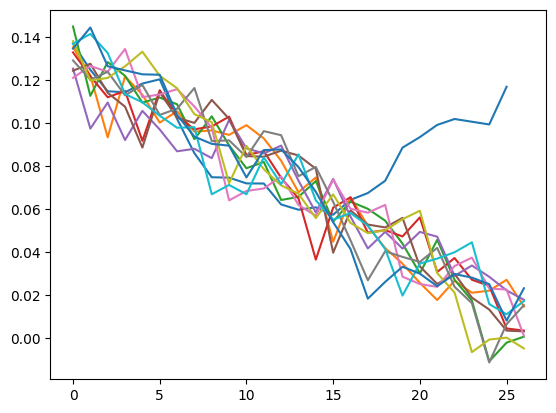

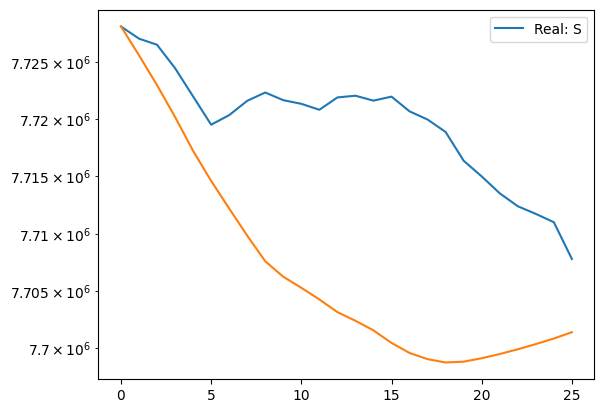

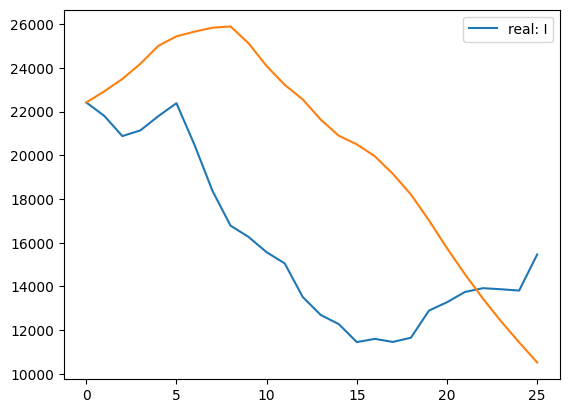

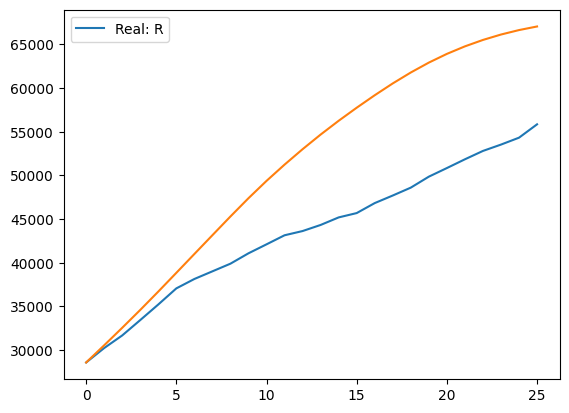

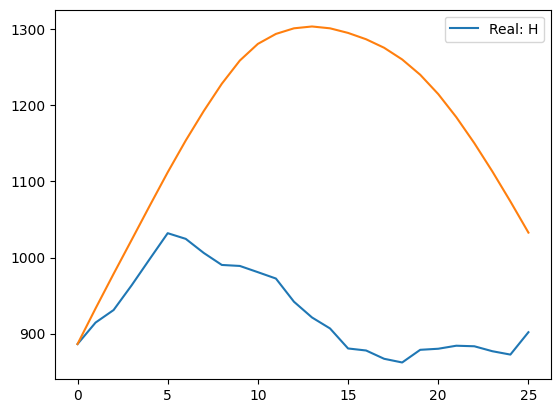

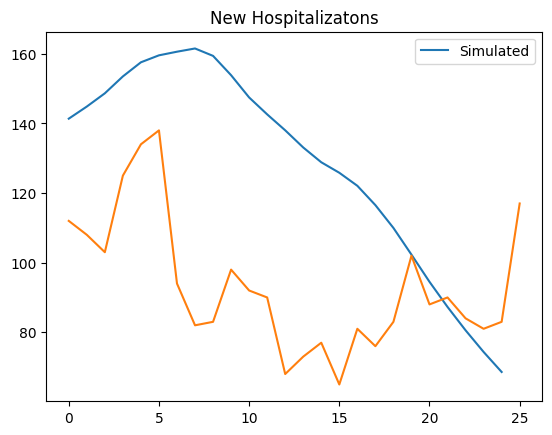

In [83]:
import numpy as np
from scipy.stats import nbinom
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
import sys
import pandas as pd

state = "AZ"

predicted_beta = pd.read_csv('../datasets/out_beta_trj_bootp.csv').to_numpy()
predicted_beta = np.delete(predicted_beta,0,1)

observations = pd.read_csv(f'../datasets/{state}_FLU_HOSPITALIZATIONS.csv').to_numpy()
observations = np.delete(observations,0,1)

estimated_state = pd.read_csv('../datasets/ESTIMATED_STATE.csv').to_numpy()
estimated_state = np.delete(estimated_state,0,1)

pf_beta = pd.read_csv('../datasets/average_beta.csv').to_numpy()
pf_beta = np.delete(pf_beta,0,1).squeeze()


t_span = [60,86]

plt.plot(pf_beta[t_span[0]:t_span[1]])
for i in range(10):
    plt.plot(predicted_beta[i,:])
plt.show()



def RHS_H(t,state,param):
    #params has all the parameters – beta, gamma
    #state is a numpy array

        S,I,R,H,new_H = state #unpack the state variables
        N = S + I + R + H #compute the total population 

        new_H = (1/param['D'])*(param['gamma']) * I

        '''The state transitions of the ODE model is below'''
        dS = -param['beta'](int(t))*(S*I)/N + (1/param['L'])*R 
        dI = param['beta'](int(t))*S*I/N-(1/param['D'])*I
        dR = (1/param['hosp']) * H + ((1/param['D'])*(1-(param['gamma']))*I)-(1/param['L'])*R 
        dH = (1/param['D'])*(param['gamma']) * I - (1/param['hosp']) * H 

        return np.array([dS,dI,dR,dH,new_H])

def beta(t):  
    if(t < 60): 
        return pf_beta[t]
    else:
        return predicted_beta[5,t-60]
    #return 0.1

state = np.array([estimated_state[t_span[0] - t] for t in range(1)])

state = np.mean(state,axis=0)


y0 = np.concatenate((state,observations[t_span[0]]))

par={
"beta":beta,
"gamma":0.06,
"hosp":10,
"L":90,
"D":10}

sol =  solve_ivp(fun=lambda t,z: RHS_H(t,z,par), 
                    #jac=lambda t,z:Jacobian(t,z,par), 
                    t_span=t_span,
                    t_eval= np.linspace(t_span[0],t_span[1],num=round(t_span[1] - t_span[0])),
                    y0=y0,
                    method='RK45')

plt.yscale('log')
labels = ['Real: S','real: I','Real: R','Real: H']
for i in range(4):
    plt.plot(estimated_state[t_span[0]:t_span[1],i],label = labels[i])
    plt.plot(sol.y[i,:])
    plt.legend()
    plt.show()

plt.title("New Hospitalizatons")
plt.plot(np.diff(sol.y[4,:]),label = "Simulated")
plt.plot(observations[t_span[0]:t_span[1]])
plt.legend()

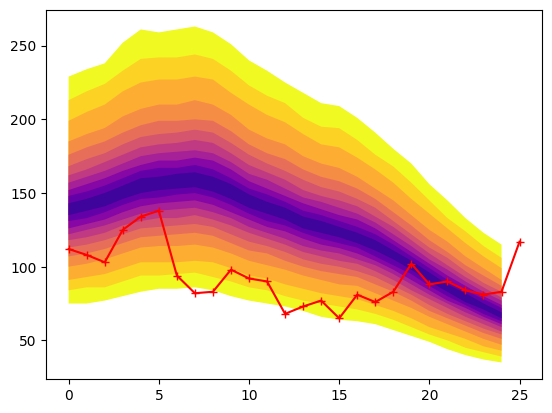

In [84]:
import numpy as np
from scipy.stats import nbinom
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
import sys
import pandas as pd
from matplotlib import cm

timeseries = np.copy(np.diff(sol.y[4,:]))

num_rv = 10000

output = np.zeros((num_rv,len(timeseries)))

r = 20

r=np.ceil(r) 

for i in range(len(timeseries)):  
    output[:,i] = nbinom.rvs(n=r, p=r/(r+timeseries[i]), size=num_rv)

quantiles_hosp = []
def quantiles(items):
        '''Returns 23 quantiles of the List passed in'''
        qtlMark = 1.00*np.array([0.010, 0.025, 0.050, 0.100, 0.150, 0.200, 0.250, 0.300, 0.350, 0.400, 0.450, 0.500, 0.550, 0.600, 0.650, 0.700, 0.750, 0.800, 0.850, 0.900, 0.950, 0.975, 0.990])
        return list(np.quantile(items, qtlMark))

for i in range(len(timeseries)):
    quantiles_hosp.append(quantiles(output[:,i]))

quantiles_hosp = np.array(quantiles_hosp)

colors = cm.plasma(np.linspace(0, 1, 12)) # type: ignore
for i in range(11):
    plt.fill_between(np.arange(len(timeseries)), quantiles_hosp[:, i], quantiles_hosp[:,22-i], facecolor=colors[11 - i], zorder=i)


#plt.plot(observations[t_span[0]:61],zorder = 13,marker = '+',color='black')
plt.plot(observations[60:86],zorder = 14,marker = '+',color='red')


